## <center> Project on Geostatistics and Reservoir Simulation course
    
# <center> Dew Point Calculation in Rich Natural Gas 


<center> Anna Kottsova, Veronika Shirokova, Maria Vetoshkina

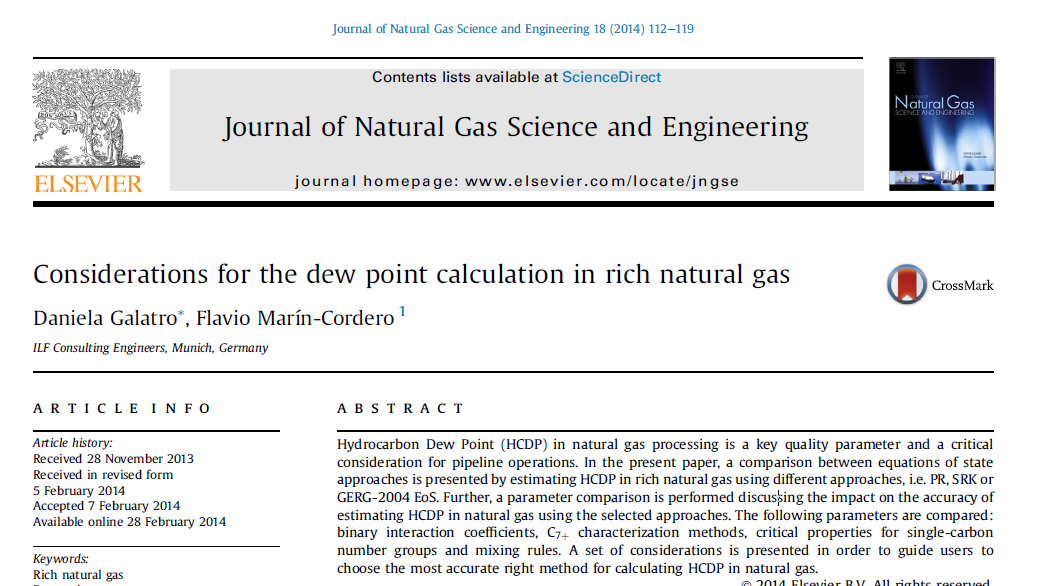

### 1. Import of necessary libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy 
from scipy.optimize import fsolve, least_squares

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### 2. Inserting of initial data:

In [2]:
#Initial data:

#Don't touch:
R = 0.0083144 #gas constant

#Insert your dew point temperature:
T = 121.8+273.15 #K 

#Insert initial pressure:
P = 30 #MPa

#Insert specific gravity of C7+:
SGC7 = 0.807

#Components (don't touch):
components = ['CO2', 'N2', 'C1', 'C2', 'C3', 'i-C4', 'n-C4', 'i-C5', 'n-C5', 'C6', 'C7'] #gas components

#Insert your mole fractions of components:
z = [0.0082, 0.0087, 0.6404, 0.1057, 0.0575, 0.0135, 0.0237, 0.0106, 0.0098, 0.0101, 0.1118] #mol.fractions of components

#Molecular weights of components (change only last one!):
MW = [44.010, 28.014, 16.043, 30.070, 44.096, 58.123, 58.123, 72.150, 72.150, 86.177, 186] #mol.weights, change the last one

#Critical parameters from Ali Danesh, 1998 (don't touch):
Tc = [304.19, 126.10, 190.56, 305.32, 369.83, 408.14, 425.12, 460.43, 469.70, 507.60, 0] #crit.temp in K
Pc = [7.382, 3.394, 4.599, 4.872, 4.248, 3.648, 3.796, 3.381, 3.370, 3.025, 0] #crit.pressures in MPa
Zc = [0.2744, 0.2917, 0.2862, 0.2793, 0.2763, 0.2824, 0.2739, 0.2701, 0.2701, 0.2659, 0] #crit.compres.factors
w = [0.2276, 0.0403, 0.0115, 0.0995, 0.1523, 0.1770, 0.2002, 0.2275, 0.2515, 0.3013, 0] #accentric factors

#Create table:
gas = pd.DataFrame({'z':z, 'MW': MW, 'Tc': Tc, 'Pc': Pc, 'Zc': Zc, 'w': w}, index=components)
gas

,z,MW,Tc,Pc,Zc,w
CO2,0.0082,44.010,304.19,7.382,0.2744,0.2276
N2,0.0087,28.014,126.10,3.394,0.2917,0.0403
C1,0.6404,16.043,190.56,4.599,0.2862,0.0115
C2,0.1057,30.070,305.32,4.872,0.2793,0.0995
C3,0.0575,44.096,369.83,4.248,0.2763,0.1523
i-C4,0.0135,58.123,408.14,3.648,0.2824,0.1770
n-C4,0.0237,58.123,425.12,3.796,0.2739,0.2002
i-C5,0.0106,72.150,460.43,3.381,0.2701,0.2275
n-C5,0.0098,72.150,469.70,3.370,0.2701,0.2515
C6,0.0101,86.177,507.60,3.025,0.2659,0.3013


### 3. Inserting of reference table with properties:

In [3]:
#DON'T TOUCH THIS KERNEL!
#General physical properties of C7+ hydrocarbons:
C =[]
for i in range(7, 46):
    C.append('C'+str(i))  #names

#Molecular weights:    
M =[96, 107, 121, 134, 147, 161, 175, 190, 206, 222, 237, 251, 263, 275, 291, 300, 312, 324, 337, 349, 360, 372, 382, 394,
   404, 415, 426, 437, 445, 456, 464, 475, 484, 495, 502, 512, 521, 531, 539]

#Specific gravities:
SG = [0.727, 0.749, 0.768, 0.782, 0.793, 0.804, 0.815, 0.826, 0.836, 0.843, 0.851, 0.856, 0.861, 0.866, 0.871, 0.876, 0.881,
     0.885, 0.888, 0.892, 0.896, 0.899, 0.902, 0.905, 0.909, 0.912, 0.915, 0.917, 0.920, 0.922, 0.925, 0.927, 0.929, 0.931,
     0.933, 0.934, 0.936, 0.938, 0.940] 

#Critical temperatures in Rankine
TC = [985, 1036, 1085, 1128, 1166, 1203, 1236, 1270, 1304, 1332, 1360, 1380, 1400, 1421, 1442, 1461, 1480, 1497, 1515, 1531, 
     1547, 1562, 1574, 1589, 1603, 1616, 1629, 1640, 1651, 1662, 1673, 1683, 1693, 1703, 1712, 1720, 1729, 1739, 1747]  #R

#Critical pressures in psia:
PC = [453, 419, 383, 351, 325, 302, 286, 270, 255, 241, 230, 222, 214, 207, 200, 193, 188, 182, 177, 173, 169, 165, 161, 158, 
     143, 138, 134, 130, 127, 124, 121, 118, 115, 112, 110, 108, 105, 103, 101] #psia

#Accentric factors
W = [0.280, 0.312, 0.348, 0.385, 0.419, 0.454, 0.484, 0.516, 0.550, 0.582, 0.613, 0.638, 0.662, 0.690, 0.717, 0.743, 
    0.768, 0.793, 0.819, 0.844, 0.868, 0.894, 0.915, 0.941, 0.897, 0.909, 0.921, 0.932, 0.942, 0.954, 0.964, 0.975, 0.985, 
    0.997, 1.006, 1.016, 1.026, 1.038, 1.048] 

#Critical volumes in ft3/lb
VC = [0.06289, 0.06264, 0.06258, 0.06273, 0.06291, 0.06306, 0.06311, 0.06316, 0.06325, 0.06342, 0.06350, 0.06362, 0.06372, 
     0.06384, 0.06394, 0.06402, 0.06408, 0.06417, 0.06431, 0.06438, 0.06443, 0.06454, 0.06459, 0.06468, 0.06469, 0.06475,
     0.06480, 0.06489, 0.06490, 0.06499, 0.06499, 0.06506, 0.06511, 0.06517, 0.06520, 0.06529, 0.06432, 0.06538, 0.06540] #ft3/lb

prop = pd.DataFrame({'MW':M, 'SG': SG, 'Tc':TC, 'Pc': PC, 'Vc': VC, 'w': W}, index=C)
prop    

,MW,SG,Tc,Pc,Vc,w
C7,96,0.727,985,453,0.06289,0.280
C8,107,0.749,1036,419,0.06264,0.312
C9,121,0.768,1085,383,0.06258,0.348
C10,134,0.782,1128,351,0.06273,0.385
C11,147,0.793,1166,325,0.06291,0.419
C12,161,0.804,1203,302,0.06306,0.454
C13,175,0.815,1236,286,0.06311,0.484
C14,190,0.826,1270,270,0.06316,0.516
C15,206,0.836,1304,255,0.06325,0.550
C16,222,0.843,1332,241,0.06342,0.582


### 4. Riazi-Daubert-Edmister method of critical properties calulation:

In [4]:
#Riazi-Daubert method of properties determination with known MW and SG:
a = [544.4, 4.5203*10**4, 1.206*10**(-2), 6.77857]
b = [0.2998, -0.8063, 0.20378, 0.401673]
c = [1.0555, 1.6015, -1.3036, -1.58262]
d = [-1.3478*10**(-4), -1.8078*10**(-3), -2.657*10**(-3), 3.77409*10**(-3)]
e = [-0.61641, -0.3084, 0.5287, 2.984036]
f = [0, 0, 2.6012*10**(-3), -4.25288*10**(-3)]
feta = ['Tc', 'Pc', 'Vc', 'Tb']

RD = pd.DataFrame({'a':a, 'b':b, 'c':c, 'd':d, 'e':e, 'f':f}, index=feta)
RD

,a,b,c,d,e,f
Tc,544.40000,0.299800,1.05550,-0.000135,-0.616410,0.000000
Pc,45203.00000,-0.806300,1.60150,-0.001808,-0.308400,0.000000
Vc,0.01206,0.203780,-1.30360,-0.002657,0.528700,0.002601
Tb,6.77857,0.401673,-1.58262,0.003774,2.984036,-0.004253


In [5]:
#RIAZI-DAUBERT + EDMISTER:
def Whitson(MW, SG):
    param =[]
    for i in feta:
        p = RD['a'][i]*MW**RD['b'][i]*SG**RD['c'][i]*np.math.exp(RD['d'][i]*MW + RD['e'][i]*SG + RD['f'][i]*MW*SG)
        param.append(p)
    crit_param = pd.DataFrame({'Feta':param}, index=feta)
    w = 3*np.log10(crit_param['Feta']['Pc']/14.7)/7/(crit_param['Feta']['Tc']/crit_param['Feta']['Tb']-1)-1
    zc = crit_param['Feta']['Pc']*crit_param['Feta']['Vc']*MW/10.73/crit_param['Feta']['Tc'] #crit compressib factor 
    tc = crit_param['Feta']['Tc']*5/9 #in K
    pc = crit_param['Feta']['Pc']*0.006894757293178 #in Pa
    return tc, pc, zc, w   

### 5. Lee-Kesler's method of critical properties determination:

In [6]:
#Lee_Kesler's method of critical properties determination:
def Lee_Kesler(MW, SG):
    Tb = fsolve(lambda x: -12272.6 + 9486.4*SG + (4.6523-3.3287*SG)*x + 10**7/x*(1-0.77084*SG - 0.02058*SG**2)*(1.3437 - 720.79/x)+(1-0.80882*SG-0.02226*SG**2)*(1.8828-181.98/x)*10**12/x**3 - MW, 0.000001)[0]
    pc = np.e**(8.3634 - 0.0566/SG - (0.24244+2.2898/SG +0.11857/SG**2)*10**(-3)*Tb + (1.4685 + 3.648/SG + 0.47227/SG**2)*10**(-7)*Tb**2 - (0.42019+1.6977/SG**2)*10**(-10)*Tb**3)
    tc = (341.7 + 811.1*SG + (0.4244 + 0.1174*SG)*Tb + (0.4669 - 3.26238*SG)*10**5/Tb)
    K = Tb**(1/3)/SG
    feta = Tb/tc
    if feta>0.8:
        w = -7.904+0.1352*K - 0.007465*K**2 + 8.359*feta + (1.408 - 0.01063*K)/feta
    else:
        w = (-np.log(pc/14.7)-5.92714 + 6.09648/feta +1.28862*np.log(feta)-0.169347*feta**6)/(15.2518 - 15.6875/feta - 13.4721*np.log(feta)+0.43577*feta**6)
    zc = 0.2918 - 0.0928*w    
    return tc*5/9, pc*0.00689475729317, zc, w*2/3

### 6. Twu's method of critical properties determination:

In [7]:
#Twu's method of critical properties determination:
def Twu(MW, SG):
    a = fsolve(lambda x: 0.843593 - 0.128624*x - 3.36159*x**3 - 13749.5*x**12 - prop['SG']['C7'], 0.000001)[0]
    tb = (1-a)*prop['Tc']['C7']
    fT = (np.e**(5*(prop['SG']['C7'] - SG))-1)*(-0.36256/tb**0.5 + (0.0398285 - 0.948125/tb**0.5)*(np.e**(5*(prop['SG']['C7'] - SG))-1))
    tc = prop['Tc']['C7']*((1+2*fT)/(1-2*fT))**2
    fV = (np.e**(4*(prop['SG']['C7']**2 - SG**2))-1)*(0.466590/tb**0.5 + (-0.182421 + 3.01721/tb**0.5)*(np.e**(4*(prop['SG']['C7']**2 - SG**2))-1))
    vc = prop['Vc']['C7']*((1+2*fV)/(1-2*fV))**2
    fP = (np.e**(0.5*(prop['SG']['C7'] - SG))-1)*((2.53262 -46.19553/tb**0.5 -0.00127885*tb)+(-11.4277 + 252.14/tb**0.5 + 0.00230535*tb)*(np.e**(0.5*(prop['SG']['C7'] - SG))-1))
    pc = prop['Pc']['C7']*(tc/prop['Tc']['C7'])*(prop['Vc']['C7']/vc)*((1+2*fP)/(1-2*fP))**2*0.5
    zc = pc*vc*MW/tc/10.73
    w = abs(0.2918 - zc)/0.0928
    return tc*5/9, pc*0.00689475729317, zc, w

### 7. Critical properties of C7+ fraction without splitting: 

In [8]:
#Function for critical parameteres of C7+ fraction without splitting:
def No_split(gas_new, method):
    if method == 'Whitson':
        gas_new['Tc']['C7'], gas_new['Pc']['C7'], gas_new['Zc']['C7'],gas_new['w']['C7'] = Whitson(gas_new['MW']['C7'], SGC7)
    elif method == 'Lee_Kesler':
        gas_new['Tc']['C7'], gas_new['Pc']['C7'], gas_new['Zc']['C7'],gas_new['w']['C7'] = Lee_Kesler(gas_new['MW']['C7'], SGC7)
    else:
        gas_new['Tc']['C7'], gas_new['Pc']['C7'], gas_new['Zc']['C7'],gas_new['w']['C7'] = Lee_Kesler(gas_new['MW']['C7'], SGC7)
      
    return gas_new    

### 8. Critical properties of groups in C7+ fraction with splitting:

$$Z_n = e^{A+B\cdot MW_n}$$

$$\cases{\sum^N_{n=7} MW_nZ_n = MW_{C7+}Z_{C7+}\\ \sum^N_{n=7} \frac{MW_{n}}{SG_{n}}Z_n = \frac{MW_{C7+}}{SG_{C7+}}Z_{C7+}}$$

In [9]:
#Pendersen's splitting method:
def Pendersen(p):
    x,y = p
    z=0
    mw_sg = 0
    for i in range(7,SCN+1):
        zi = np.math.exp(x + y*prop['MW']['C'+str(i)])
        z += zi
        mw_sgi = prop['MW']['C'+str(i)]/prop['SG']['C'+str(i)]*np.math.exp(x + y*prop['MW']['C'+str(i)])
        mw_sg += mw_sgi
    return (z - gas['z']['C7'], mw_sg - gas['MW']['C7']/SGC7*gas['z']['C7'])    


#Splitting and critical parameters determination:
def Splitting(gas_spl, Pendersen, method):
    x,y = fsolve(Pendersen, (0.00000001,0.00000001))
    A = x
    B = y
    z = []
    index = []
    for i in range(7,SCN+1):
        index.append('C'+str(i))
        zi = np.e**(A + B*prop['MW']['C'+str(i)])
        z.append(zi)
    plusfrac =pd.DataFrame({'z':z}, index=index)
    plusfrac['MW'] = prop['MW']['C7':'C'+str(SCN-1)]
    plusfrac['Pc'] = prop['Pc']['C7':'C'+str(SCN-1)]*0.006894757293178 #MPa
    plusfrac['Tc'] = prop['Tc']['C7':'C'+str(SCN-1)]*5/9 #K
    plusfrac['Zc'] = prop['Pc']['C7':'C'+str(SCN-1)]*prop['Vc']['C7':'C'+str(SCN-1)]*prop['MW']['C7':'C'+str(SCN-1)]/10.73/prop['Tc']['C7':'C'+str(SCN-1)]
    plusfrac['w'] = prop['w']['C7':'C'+str(SCN-1)]
    plusfrac['MW']['C'+str(SCN)] = (gas_spl['z']['C7']*gas_spl['MW']['C7']\
                                    - sum(plusfrac['MW']['C7':'C'+str(SCN-1)]*plusfrac['z']['C7':'C'+str(SCN-1)]))/plusfrac['z']['C'+str(SCN)]
    SG = plusfrac['MW']['C'+str(SCN)]*plusfrac['z']['C'+str(SCN)]/(gas_spl['z']['C7']*gas_spl['MW']['C7']/SGC7- sum(plusfrac['MW']['C7':'C'+str(SCN-1)]*plusfrac['z']['C7':'C'+str(SCN-1)]/prop['SG']['C7':'C'+str(SCN-1)]))
    
    if method == 'Whitson':
        plusfrac['Tc']['C'+str(SCN)], plusfrac['Pc']['C'+str(SCN)], plusfrac['Zc']['C'+str(SCN)],plusfrac['w']['C'+str(SCN)] = Whitson(plusfrac['MW']['C'+str(SCN)], SG)
    elif method == 'Lee_Kesler':
        plusfrac['Tc']['C'+str(SCN)], plusfrac['Pc']['C'+str(SCN)], plusfrac['Zc']['C'+str(SCN)],plusfrac['w']['C'+str(SCN)] = Lee_Kesler(plusfrac['MW']['C'+str(SCN)], SG)
    else:
        plusfrac['Tc']['C'+str(SCN)], plusfrac['Pc']['C'+str(SCN)], plusfrac['Zc']['C'+str(SCN)],plusfrac['w']['C'+str(SCN)] = Twu(plusfrac['MW']['C'+str(SCN)], SG)
    gas_spl = gas_spl.drop(labels = 'C7', axis=0)
    gas_spl = pd.concat([gas_spl, plusfrac], axis=0)
    return gas_spl

### 9. Determination of interaction coefficient:

$$1-k_{ij} = \left[\frac{2(T_{ci}T_{cj})^{0.5}}{T_{ci} + T_{cj}}\right]^{Z_{cij}}$$

$$Z_{cij} = \frac{Z_{ci}+Z_{cj}}{2}$$

In [10]:
#Interaction coefficient determination:
def interactions(gas_new):
    components = gas_new.index.get_values()
    k = np.zeros((np.size(components),np.size(components)), dtype='single')
    Kij = pd.DataFrame(k, columns=components, index=components)
    for i in components:
        for j in components:
            if i==j:
                Kij[i][j] = 0
            else:
                zij = (gas_new['Zc'][i] + gas_new['Zc'][j])/2
                Kij[i][j] = 1 - (2*np.sqrt(gas_new['Tc'][i]*gas_new['Tc'][j])/(gas_new['Tc'][i]+gas_new['Tc'][j]))**zij
                
    return Kij         

### 10. Implementation of different EoS methods:

- General equation for all three types:

$$ P = \frac{RT}{v - b} - \frac{a_c\lambda^2}{(v-b_1)(v-b_2)} $$ 

__Considered EoS types:__

- __Soave-Redlich-Kwong EoS (SRK)__

$$ \lambda_{SRK} = 1 + \left( 0.480 + 1.547 w - 0.176 w^2 \right) \left( 1 - \frac{T}{T_c} \right)$$,

where:

$a_c$ - attractive force parameter;

$b$ - repulsive force parameter (co-volume);

$b_1$, $b_2$ - parameters determined from $b$ according to the table;

$w$ - acentric factor.

Parameters for SRK EoS:

$$ \begin{matrix} a_c & b & b_1 & b_2 \\ \frac{0.42748 R^2 T_c^2}{P_c} & \frac{0.08664RT_c}{P_c} & -b & 0\end{matrix} $$

Can be rewritten as

$$ Z^3 - Z^2 + (A - B - B^2) Z - AB = 0 $$

where 

$$ A = \frac{a P}{(RT)^2} $$

$$ B = \frac{bP}{RT}$$

- __Peng-Robinson EoS (PR)__

$$ \lambda_{PR} = 1 + \left(0.37464 + 1.5422 w - 0.26992 w^2 \right) \left( 1- \frac{T}{T_c} \right) $$

Parameters for PR EoS:

$$ \begin{matrix} a_c & b & b_1 & b_2 \\ \frac{0.45724 R^2 T_c^2}{P_c} & \frac{0.07788RT_c}{P_c} & -b(1+\sqrt{2}) & -b(1-\sqrt{2} )\end{matrix} $$

Can be rewritten

$$ Z^3 - (1-B) Z^2 + (A - 2B - 3B^2) Z - (AB - B^2 - B^3) = 0 $$

- __Peng-Robinson Modified EoS (PRM)__

$$ a = 0.45724 \left( \frac{R^2T^2_c}{P_c} \right) \alpha (T) $$


$$ b = 0.07780 \left( \frac{RT_c}{P_c} \right) \beta (T) $$


$$ \alpha(T) = \exp(1 - n^{lnT_r})$$
<br>
$$ \beta (T) = 1 + m(1 - T_r)$$
<br>
$$ m = 0.2476 - 0.8857 w + 0.1900 W^2 $$
<br>
$$ n = 1.7309 + 1.6571 w + 0.1554 w^2 $$


Reduced temperature: 


$$ T_r  = \frac{T}{T_c} $$

PRM rewritten:

$$  Z^3 - (1-B) Z^2 + (A - 2B - 3B^2) Z - (AB - B^2 - B^3) = 0 $$

- Van der Waals mixing rules:

$$A = \frac{(a \alpha)_m P}{(RT)^2} \tag{9}$$<br>
$$B = \frac{b_m P}{RT} \tag{10}$$<br>

$$(a \alpha)_m = \sum^N_{i=1} \sum^N_{j=1} (x_i x_j \sqrt{a_i \alpha_i a_j \alpha_j}(1 - K_{ij})) \tag{11}$$
<br>
$$b_m = \sum^N_{i=1} (x_i b_i) \tag{12}$$

In [11]:
#EOS methods:
def EOS(method1, gas_eos, Pd):
    
    Compon = gas_eos.index.get_values()
    A_B = np.zeros([2,2], dtype = 'single')
    A_B = pd.DataFrame(A_B, 
                       index=['x', 'y'], 
                       columns=['A', 'B'])
    
    Mixings = np.zeros([2,2], dtype = 'single')
    Mixings = pd.DataFrame(A_B, 
                       index=['x', 'y'], columns=['a_alfa_m', 'b_m'])
    
    K = interactions(gas_eos)
    if method1 == 'PR':
        gas_eos['ai'] = (0.45724*R**2*gas_eos['Tc']**2)/gas_eos['Pc'] 
        gas_eos['bi'] = (0.07780*R**1*gas_eos['Tc']**1)/gas_eos['Pc'] 
        gas_eos['m'] = 0.37464 + 1.5422*gas_eos['w'] - 0.26992*gas_eos['w']**2 
        gas_eos['alfa_i'] = (1+gas_eos['m']*(1-np.sqrt(T/gas_eos['Tc'])))**2 
    elif method1 == 'SRK':
        gas_eos['ai'] = (0.42748*R**2*gas_eos['Tc']**2)/gas_eos['Pc'] 
        gas_eos['bi'] = (0.08664*R**1*gas_eos['Tc']**1)/gas_eos['Pc'] 
        gas_eos['m'] = 0.480 + 1.547*gas_eos['w'] - 0.176*gas_eos['w']**2  
        gas_eos['alfa_i'] = (1+gas_eos['m']*(1-np.sqrt(T/gas_eos['Tc'])))**2 
    else:
        gas_eos['n'] = 1.7309 + 1.6571*gas_eos['w'] + 0.1554*gas_eos['w']**2
        gas_eos['m'] = 0.2476 - 0.8857*gas_eos['w'] + 0.1900*gas_eos['w']**2
        gas_eos['alfa_i'] = np.math.e**(1-gas_eos['n']**np.log(T/gas_eos['Tc']))
        gas_eos['beta_i'] = 1 + gas_eos['m']*(1-T/gas_eos['Tc']) 
        gas_eos['ai'] = (0.45724*R**2*gas_eos['Tc']**2)/gas_eos['Pc']#* gas['alfa_i'] 
        gas_eos['bi'] = (0.07780*R*gas_eos['Tc'])/gas_eos['Pc']* gas_eos['beta_i'] 
        
        
    for i in ['x', 'y']:
        a_alfa_m = 0
        beta = 0
        for j in Compon:
            for m in Compon:
                #if method == 'PR' or method == 'SRK':
                beta = gas_eos[i][j]*gas_eos[i][m]*np.sqrt(gas_eos['ai'][j]*gas_eos['ai'][m]*gas_eos['alfa_i'][j]*gas_eos['alfa_i'][m])*(1-K[m][j])
                #else:   
                    #beta = gas[i][j]*gas[i][m]*np.sqrt(gas['ai'][j]*gas['ai'][m])*(1-K)
    
                a_alfa_m = a_alfa_m + beta
        
        Mixings['a_alfa_m'][i] = a_alfa_m
                
        A_B['A'][i] = (a_alfa_m*Pd)/(R*T)**2 #equation 9

        b_m = sum(gas_eos[i]*gas_eos['bi'])
            
        Mixings['b_m'][i] = b_m
        
        A_B['B'][i] = (b_m*Pd)/(R*T) #equation 10
        
        if method1 == 'PR' or method1 == 'MPR':
            Coef = [1, A_B['B'][i]-1, A_B['A'][i]-3*A_B['B'][i]**2-2*A_B['B'][i],
                    -(A_B['A'][i]*A_B['B'][i]-A_B['B'][i]**2-A_B['B'][i]**3)] 
        else:
            Coef = [1, -1, A_B['A'][i]-A_B['B'][i]**2-A_B['B'][i], -A_B['A'][i]*A_B['B'][i]] 
        
        Z_Roots = np.roots(Coef)
        Z_Roots = Z_Roots[np.isreal(Z_Roots)]
        
        
        if i == 'x':
            Z_L = np.min(np.real(Z_Roots))   
        else:
            Z_V = np.max(np.real(Z_Roots))
            
    Z = [Z_L, Z_V]
    Z_factor = pd.DataFrame(Z, 
                     index=['x', 'y'], 
                     columns=['Z'])
    
    return A_B, Z_factor, Mixings, gas_eos

### 11. Fugacity and fugacity coefficient calculation for equilibrium ratio constant $K$ correction:

In [12]:
#Fugacity function:
def fugacity(gas_eos, A_B, Z_factor, Mixings, Pd):
    gas_fug = gas_eos
    Compon = gas_fug.index.get_values()
    Psi=np.zeros((np.size(Compon),2), dtype='single')
    Psi = pd.DataFrame(Psi, index=Compon, columns=['x', 'y'])
    K = interactions(gas_fug)
    for i in ['x', 'y']:
        for j in Compon:
            psi = 0
            hg = 0
            for m in Compon:
                hg = gas_fug[i][m]*np.sqrt(gas_fug['ai'][j]*gas_fug['ai'][m]*gas_fug['alfa_i'][j]*gas_fug['alfa_i'][m])*(1-K[m][j])
                psi += hg
                
            Psi[i][j] = psi  
            
        gas_fug['Fi_'+i] = np.exp(gas_fug['bi']/Mixings['b_m'][i] * (Z_factor['Z'][i]-1) - np.log(Z_factor['Z'][i]-\
                        A_B['B'][i])-A_B['A'][i]/(-2*np.sqrt(2)*A_B['B'][i])*\
                        (2*Psi[i]/Mixings['a_alfa_m'][i] - gas_fug['bi']/Mixings['b_m'][i])*\
                        np.log((Z_factor['Z'][i] + (1-np.sqrt(2))*A_B['B'][i])/(Z_factor['Z'][i] + (1+np.sqrt(2))*A_B['B'][i])))
        gas_fug['f_'+i] =  gas_fug['Fi_'+i]*gas_fug[i]*Pd
        
    return gas_fug

### 12. Correction of $K$ and dew point pressure determination:

In [13]:
#Checking and iterations!
def check(gas_fug, Pd, method1):
    Pd_iter = [Pd] #array with assumed dew-point pressure
    iterat= 0 # number of iterations
    err = 0.00001 #initial value of error (random)
    while err>10**(-12):
        err = sum((1 - gas_fug['f_x']/gas_fug['f_y'])**2) 
        if err<=10**(-12):
            Pd = Pd
            iterat = iterat
            break
        else:    
            gas_fug['K'] = gas_fug['K_new'] #update of Ki
            gas_fug['x'] = gas_fug['y']/gas_fug['K'] #update of vapour phase composition
            Pdn = Pd/sum(gas_fug['y']/gas_fug['K']) #update of Pb
            Pd = Pdn
            Pd_iter.append(Pd)
            
            A_B, Z_factor, Mixings, gas_eos = EOS(method1,gas_fug, Pd) 
            gas_fug= fugacity(gas_eos, A_B, Z_factor, Mixings, Pd)

            gas_fug['K_new'] = gas_fug['Fi_x']/gas_fug['Fi_y']
            iterat +=1
            continue  
        
    return Pd

### 13. All calculations on current gas:

In [14]:
#SCN = single carbon number - number of groups for C7+ splitting:
SCN = int(27.517*np.log(gas['MW']['C7'])-126.79) 

#Initial guess for dew-point pressure:
Pd = P

In [15]:
#Without splitting:
methods1 = ['PR','SRK', 'MPR']
methods2 = ['Whitson', 'Lee_Kesler', 'Twu']
Pd_all0 = []
Crit_method0 = []
EOS_method0 = []
for i in methods2:
    gas_new=gas.copy()
    gas_new = No_split(gas_new, i)
    gas_new['K'] = gas_new['Pc']/Pd*np.exp(5.37*(1+gas_new['w'])*(1-gas_new['Tc']/T)) 
    gas_new['y'] = gas_new['z'] 
    gas_new['x'] = gas_new['y']/gas_new['K'] 
    for j in methods1:
        gas_eos = gas_new.copy()
        A_B, Z_factor, Mixings, gas_eos = EOS(j, gas_eos, Pd)
        gas_fug = fugacity(gas_eos, A_B, Z_factor, Mixings, Pd)
        gas_fug['K_new'] = gas_fug['Fi_x']/gas_fug['Fi_y']
        Pdi = check(gas_fug, Pd, j)
        Pd_all0.append(Pdi)
        Crit_method0.append(i)
        EOS_method0.append(j)

In [16]:
noSPLIT = pd.DataFrame({'Crit_param':Crit_method0, 'EOS':EOS_method0, 'Pd':Pd_all0})
noSPLIT

,Crit_param,EOS,Pd
0,Whitson,PR,37.757194
1,Whitson,SRK,42.023064
2,Whitson,MPR,37.364285
3,Lee_Kesler,PR,36.322539
4,Lee_Kesler,SRK,39.044613
5,Lee_Kesler,MPR,35.808110
6,Twu,PR,36.322539
7,Twu,SRK,39.044613
8,Twu,MPR,35.808110


In [17]:
#With splitting:
Pd_all = []
Crit_method = []
EOS_method = []
for i in methods2:
    gas_spl = gas.copy()
    gas_spl = Splitting(gas_spl,Pendersen, i)
    gas_spl['K'] = gas_spl['Pc']/Pd*np.exp(5.37*(1+gas_spl['w'])*(1-gas_spl['Tc']/T))
    gas_spl['y'] = gas_spl['z']
    gas_spl['x'] = gas_spl['y']/gas_spl['K'] 
    for j in methods1:
        gas_eos = gas_spl.copy()
        A_B, Z_factor, Mixings, gas_eos = EOS(j, gas_eos, Pd)
        gas_fug = fugacity(gas_eos, A_B, Z_factor, Mixings, Pd)
        gas_fug['K_new'] = gas_fug['Fi_x']/gas_fug['Fi_y']
        Pdi = check(gas_fug, Pd, j)
        Pd_all.append(Pdi)
        Crit_method.append(i)
        EOS_method.append(j)   

In [18]:
SPLIT = pd.DataFrame({'Crit_param':Crit_method, 'EOS':EOS_method, 'Pd':Pd_all})
SPLIT

,Crit_param,EOS,Pd
0,Whitson,PR,36.484295
1,Whitson,SRK,40.934656
2,Whitson,MPR,36.883224
3,Lee_Kesler,PR,35.567897
4,Lee_Kesler,SRK,39.234511
5,Lee_Kesler,MPR,35.439286
6,Twu,PR,38.191860
7,Twu,SRK,42.811656
8,Twu,MPR,38.194829


In [19]:
def error_calc(df, Pd_true):
    df['Real DP'] = Pd_true #MPa
    for i in df.index.get_values():
        df['Error, %'] = abs(Pd_true - df['Pd'])/Pd_true * 100
        
    return df    

In [20]:
#Please insert here the true dew point pressure:
Pd_true = 36.05 #MPa

In [21]:
error_calc(noSPLIT, Pd_true)
noSPLIT

,Crit_param,EOS,Pd,Real DP,"Error, %"
0,Whitson,PR,37.757194,36.05,4.735627
1,Whitson,SRK,42.023064,36.05,16.568832
2,Whitson,MPR,37.364285,36.05,3.645728
3,Lee_Kesler,PR,36.322539,36.05,0.756002
4,Lee_Kesler,SRK,39.044613,36.05,8.306831
5,Lee_Kesler,MPR,35.808110,36.05,0.670985
6,Twu,PR,36.322539,36.05,0.756002
7,Twu,SRK,39.044613,36.05,8.306831
8,Twu,MPR,35.808110,36.05,0.670985


In [22]:
error_calc(SPLIT, Pd_true)
SPLIT

,Crit_param,EOS,Pd,Real DP,"Error, %"
0,Whitson,PR,36.484295,36.05,1.204701
1,Whitson,SRK,40.934656,36.05,13.549671
2,Whitson,MPR,36.883224,36.05,2.311301
3,Lee_Kesler,PR,35.567897,36.05,1.337318
4,Lee_Kesler,SRK,39.234511,36.05,8.833595
5,Lee_Kesler,MPR,35.439286,36.05,1.694075
6,Twu,PR,38.191860,36.05,5.941360
7,Twu,SRK,42.811656,36.05,18.756326
8,Twu,MPR,38.194829,36.05,5.949594


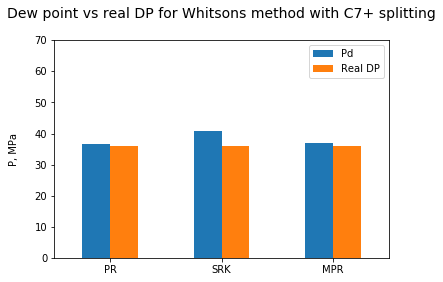

In [23]:
Wsplit = SPLIT.iloc[:3][:]
w = Wsplit.plot.bar(y = ['Pd', 'Real DP'])
plt.ylim(0, 70)
plt.ylabel('P, MPa\n')
w.set_xticklabels(Wsplit['EOS'], horizontalalignment = 'center', rotation = 0)
w.set_title('Dew point vs real DP for Whitsons method with C7+ splitting\n', fontsize = 14);

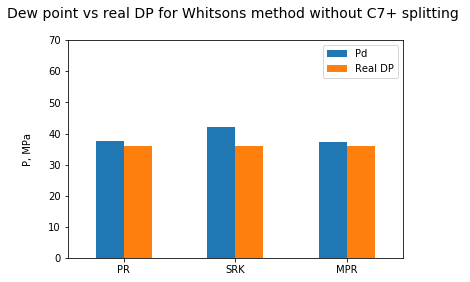

In [24]:
Wnosplit = noSPLIT.iloc[:3][:]
w = Wnosplit.plot.bar(y = ['Pd', 'Real DP'])
plt.ylim(0, 70)
plt.ylabel('P, MPa\n')
w.set_xticklabels(Wsplit['EOS'], horizontalalignment = 'center', rotation = 0)
w.set_title('Dew point vs real DP for Whitsons method without C7+ splitting \n', fontsize = 14);

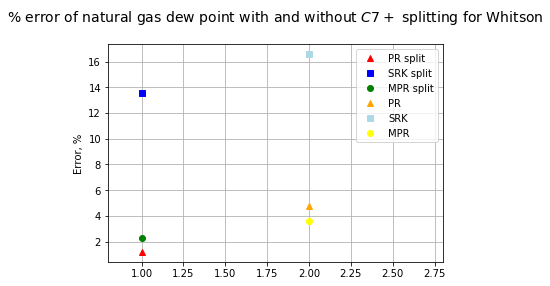

In [36]:
a = Wsplit['Error, %'][0]
b = Wsplit['Error, %'][1]
c = Wsplit['Error, %'][2]

a1 = Wnosplit['Error, %'][0]
b1 = Wnosplit['Error, %'][1]
c1 = Wnosplit['Error, %'][2]

plt.xlim(0.8, 2.8)
plt.plot(1, a, '^', label = 'PR split', c = 'red')
plt.plot(1, b, 's', label = 'SRK split', c= 'blue')
plt.plot(1, c, 'o', label = 'MPR split', c = 'green')

plt.plot(2, a1, '^', label = 'PR', c = 'orange')
plt.plot(2, b1, 's', label = 'SRK', c = 'lightblue')
plt.plot(2, c1, 'o', label = 'MPR', c ='yellow')
plt.ylabel('Error, %')
plt.title('% error of natural gas dew point with and without $C7+$ splitting for Whitson\n', fontsize = 14)
plt.legend()
plt.grid()

<Figure size 1152x648 with 0 Axes>

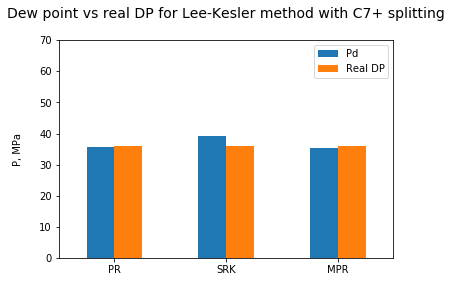

In [26]:
LKsplit = SPLIT.iloc[3:6][:]
x = np.arange(0, 3, 1)
w = plt.figure(figsize = (16, 9))
w = LKsplit.plot.bar(y = ['Pd', 'Real DP'])
plt.ylim(0, 70)
plt.ylabel('P, MPa\n')
w.set_xticklabels(LKsplit['EOS'], horizontalalignment = 'center', rotation = 0)
w.set_title('Dew point vs real DP for Lee-Kesler method with C7+ splitting\n', fontsize = 14);

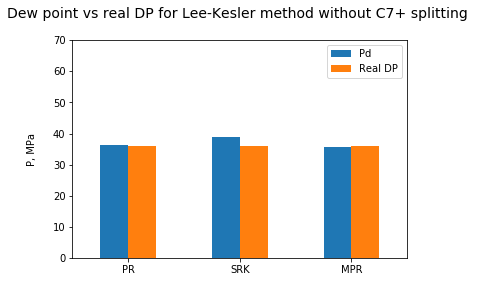

In [27]:
LKnosplit = noSPLIT.iloc[3:6][:]
x = np.arange(0, 3, 1)
w = LKnosplit.plot.bar(y = ['Pd', 'Real DP'])
w.set_xticklabels(LKnosplit['EOS'], horizontalalignment = 'center', rotation = 0)
plt.ylim(0, 70)
plt.ylabel('P, MPa\n')
w.set_title('Dew point vs real DP for Lee-Kesler method without C7+ splitting \n', fontsize = 14);

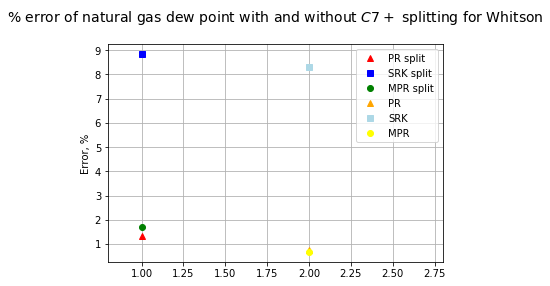

In [35]:
a = LKsplit['Error, %'][3]
b = LKsplit['Error, %'][4]
c = LKsplit['Error, %'][5]

a1 = LKnosplit['Error, %'][3]
b1 = LKnosplit['Error, %'][4]
c1 = LKnosplit['Error, %'][5]

plt.xlim(0.8, 2.8)

plt.plot(1, a, '^', label = 'PR split', c = 'red')
plt.plot(1, b, 's', label = 'SRK split', c= 'blue')
plt.plot(1, c, 'o', label = 'MPR split', c = 'green')

plt.plot(2, a1, '^', label = 'PR', c = 'orange')
plt.plot(2, b1, 's', label = 'SRK', c = 'lightblue')
plt.plot(2, c1, 'o', label = 'MPR', c ='yellow')
plt.ylabel('Error, %')
plt.title('% error of natural gas dew point with and without $C7+$ splitting for Whitson\n', fontsize = 14)
plt.legend()
plt.grid()

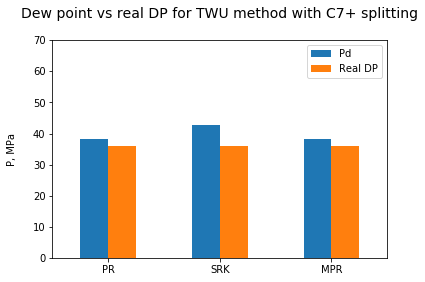

In [29]:
TWsplit = SPLIT.iloc[6:9][:]

x = np.arange(0, 3, 1)
w = TWsplit.plot.bar(y = ['Pd', 'Real DP'])
plt.ylim(0, 70)
plt.ylabel('P, MPa\n')
w.set_xticklabels(LKsplit['EOS'], horizontalalignment = 'center', rotation = 0)
w.set_title('Dew point vs real DP for TWU method with C7+ splitting\n', fontsize = 14);

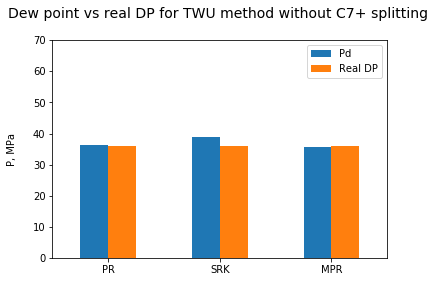

In [30]:
TWnosplit = noSPLIT.iloc[6:9][:]
x = np.arange(0, 3, 1)
w = TWnosplit.plot.bar(y = ['Pd', 'Real DP'])
plt.ylim(0, 70)
plt.ylabel('P, MPa\n')
w.set_xticklabels(TWnosplit['EOS'], horizontalalignment = 'center', rotation = 0)
w.set_title('Dew point vs real DP for TWU method without C7+ splitting \n', fontsize = 14);

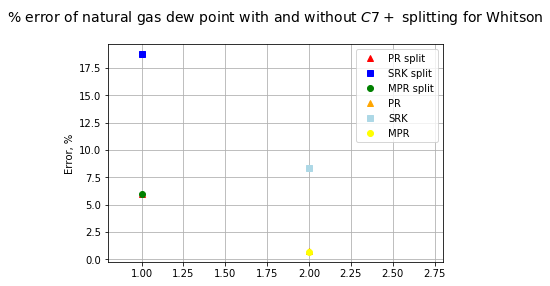

In [34]:
a = TWsplit['Error, %'][6]
b = TWsplit['Error, %'][7]
c = TWsplit['Error, %'][8]

a1 = TWnosplit['Error, %'][6]
b1 = TWnosplit['Error, %'][7]
c1 = TWnosplit['Error, %'][8]

plt.xlim(0.8, 2.8)

plt.plot(1, a, '^', label = 'PR split', c = 'red')
plt.plot(1, b, 's', label = 'SRK split', c= 'blue')
plt.plot(1, c, 'o', label = 'MPR split', c = 'green')

plt.plot(2, a1, '^', label = 'PR', c = 'orange')
plt.plot(2, b1, 's', label = 'SRK', c = 'lightblue')
plt.plot(2, c1, 'o', label = 'MPR', c ='yellow')
plt.ylabel('Error, %')
plt.title('% error of natural gas dew point with and without $C7+$ splitting for Whitson\n', fontsize = 14)
plt.legend()
plt.grid()